In [1]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.


In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

In [3]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis



In [4]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


--2024-11-30 17:16:08--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-11-30 17:16:09--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc51c77042df9e26f2e77abd80e4.dl.dropboxusercontent.com/cd/0/inline/CfanBNrI1IdZJmwtVssmu9eBSX6f0MX_qJ3zshRu5AZj-2j-rOTIvK6Bdn9v1K0T-dGqte3Yt1ApT0X49_fSwXBSS5lqPXQFO09XKvml3S16SPv8Nva4azPW5jGD7418q30/file# [following]
--2024-11-30 17:16:09--  https://uc51c77042df9e26f2e77abd80e4.dl.dropboxusercontent.com/cd/0/inline/CfanBNrI1IdZJm

In [5]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


In [6]:
from google.colab import drive
from skimage.io import imread
from skimage.transform import resize
import os
import sys
from IPython.display import clear_output
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (15,4)
from PIL import Image

from time import time
import numpy as np
import copy
from dataclasses import dataclass, asdict
import pickle

drive.mount('/content/drive', force_remount=True)
drive_path = "/content/drive/MyDrive/PH2Dataset"

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

Mounted at /content/drive
cuda


In [7]:
import os
from tqdm import tqdm
from skimage.io import imread

images = []
lesions = []

# Path to the root directory of the dataset
root_path = "/content/drive/MyDrive/PH2Dataset/PH2 Dataset images"

all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        image_files = os.listdir(directory)
        if image_files:
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        lesion_files = os.listdir(directory)
        if lesion_files:
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

print(f"Loaded {len(images)} images and {len(lesions)} lesion masks.")


Processing Directories: 100%|██████████| 627/627 [00:02<00:00, 228.66it/s]

Loaded 200 images and 200 lesion masks.


In [8]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [9]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [10]:
len(lesions)


200

In [11]:
# Save arrays to a file
np.save(drive_path+'X.npy', X)
np.save(drive_path+'Y.npy', Y)

In [12]:
# Load arrays back
loaded_X = np.load(drive_path+'X.npy')
loaded_Y = np.load(drive_path+'Y.npy')

In [13]:
X = copy.copy(loaded_X)
Y = copy.copy(loaded_Y)

In [14]:
ix = np.random.choice(len(X), len(X), False)
tr, ts = np.split(ix, [170])

In [15]:
X_test = copy.copy(X[ts])
Y_test = copy.copy(Y[ts])

In [16]:
X = copy.copy(X[tr])
Y = copy.copy(Y[tr])

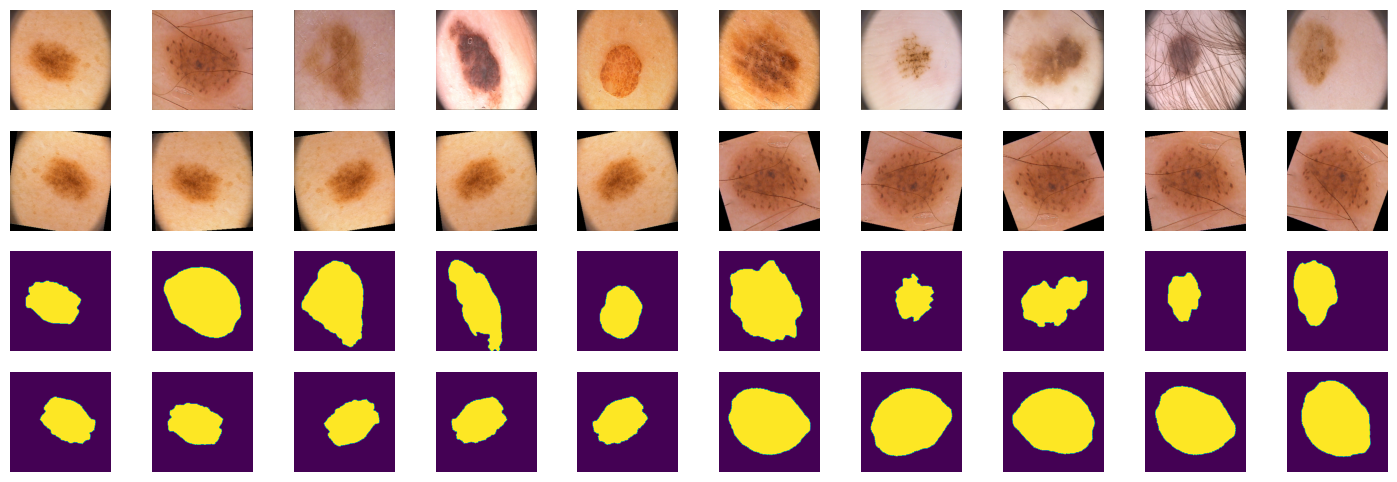

In [17]:
def train_transforms(x, seed):
  torch.manual_seed(seed)
  random_transform = transforms.Compose([
      transforms.RandomRotation(degrees=(-25, 25)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
  ])

  RESCALE_SIZE = 256
  data_transforms = transforms.Compose([
      random_transform,
      transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
      transforms.ToTensor()
  ])

  return data_transforms(x)

transformed_images = []
transformed_labels = []
num_augmentations_per_sample = 5

for img, label in zip(X, Y):
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    pil_label = Image.fromarray((label * 255).astype(np.uint8))
    for _ in range(num_augmentations_per_sample):
        seed = np.random.randint(0, 2**32)
        transformed_img = train_transforms(pil_img, seed)
        transformed_label = train_transforms(pil_label, seed)

        transformed_images.append(transformed_img.numpy())
        transformed_labels.append(transformed_label.numpy())

transformed_images = np.array(transformed_images)
transformed_labels = np.array(transformed_labels)

transformed_images = np.moveaxis(transformed_images, 1, -1)
transformed_labels = np.moveaxis(transformed_labels, 1, -1).squeeze()
fig, axes = plt.subplots(4, 10, figsize=(18, 6))

for i in range(10):
    axes[0, i].imshow(X[i])
    axes[0, i].axis("off")

    axes[1, i].imshow(transformed_images[i])
    axes[1, i].axis("off")

    axes[2, i].imshow(Y[i])
    axes[2, i].axis("off")

    axes[3, i].imshow(transformed_labels[i])
    axes[3, i].axis("off")

plt.show()

print("Original dataset shape:", X.shape, Y.shape)
print("Augmented dataset shape:", transformed_images.shape, transformed_labels.shape)

In [18]:
import os
import pandas as pd

# Load metadata from PH2_dataset.txt
metadata_path = "/content/Transformer-Explainability/PH2Dataset/PH2_dataset.txt"

# Load metadata with proper delimiters and clean it
metadata = pd.read_csv(metadata_path, sep="\\|", engine="python", skipinitialspace=True)
metadata.columns = metadata.columns.str.strip()  # Clean column names
metadata = metadata.dropna(how="all", axis=1)  # Drop empty columns

# Extract relevant columns
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names
#metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)
# Identify rows with missing or non-numeric values
print(metadata["Clinical Diagnosis"].isna().sum())  # Count missing values
print(metadata[metadata["Clinical Diagnosis"].isna()])  # Display problematic rows

# Drop rows with NaN or non-numeric values
metadata = metadata.dropna(subset=["Clinical Diagnosis"])
metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)

# Clean the Clinical Diagnosis column
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names

# Handle missing values in Clinical Diagnosis
metadata["Clinical Diagnosis"] = pd.to_numeric(metadata["Clinical Diagnosis"], errors="coerce")  # Convert to numeric
metadata = metadata.dropna(subset=["Clinical Diagnosis"])  # Drop rows with NaN
metadata["Clinical Diagnosis"] = metadata["Clinical Diagnosis"].astype(int)  # Convert to int

print(metadata.head())


Original dataset shape: (170, 256, 256, 3) (170, 256, 256)
Augmented dataset shape: (850, 256, 256, 3) (850, 256, 256)
20
     Name  Clinical Diagnosis
200  None                 NaN
201  None                 NaN
202  None                 NaN
203  None                 NaN
204  None                 NaN
205  None                 NaN
206  None                 NaN
207  None                 NaN
208  None                 NaN
209  None                 NaN
210  None                 NaN
211  None                 NaN
212  None                 NaN
213  None                 NaN
214  None                 NaN
215  None                 NaN
216  None                 NaN
217  None                 NaN
218  None                 NaN
219  None                 NaN
     Name  Clinical Diagnosis
0  IMD003                   0
1  IMD009                   0
2  IMD016                   0
3  IMD022                   0
4  IMD024                   0


In [19]:
import os
from tqdm import tqdm
from skimage.io import imread

images = []
image_names = []  # Store names for linking with metadata
lesions = []

# Path to the root directory of the dataset
root_path = "/content/drive/MyDrive/PH2Dataset/PH2 Dataset images"

# Gather all directories in the root path
all_dirs = [os.path.join(root, d) for root, dirs, _ in os.walk(root_path) for d in dirs]

# Process directories with tqdm
for directory in tqdm(all_dirs, desc="Processing Directories"):
    if directory.endswith('_Dermoscopic_Image'):
        # Load the first image file in the directory
        image_files = os.listdir(directory)
        if image_files:  # Ensure the directory is not empty
            image_names.append(os.path.basename(directory).replace('_Dermoscopic_Image', ''))
            images.append(imread(os.path.join(directory, image_files[0])))
    if directory.endswith('_lesion'):
        # Load the first lesion file in the directory
        lesion_files = os.listdir(directory)
        if lesion_files:  # Ensure the directory is not empty
            lesions.append(imread(os.path.join(directory, lesion_files[0])))

print(f"Loaded {len(images)} images and {len(lesions)} lesion masks.")


Processing Directories: 100%|██████████| 627/627 [00:02<00:00, 260.04it/s]

Loaded 200 images and 200 lesion masks.


In [20]:
import pandas as pd

# Load metadata
metadata_path = "/content/Transformer-Explainability/PH2Dataset/PH2_dataset.txt"
metadata = pd.read_csv(metadata_path, sep="\\|", engine="python", skipinitialspace=True)
metadata.columns = metadata.columns.str.strip()  # Clean column names
metadata = metadata.dropna(how="all", axis=1)  # Drop empty columns
metadata = metadata[["Name", "Clinical Diagnosis"]]
metadata["Name"] = metadata["Name"].str.strip()  # Clean image names
metadata["Clinical Diagnosis"] = pd.to_numeric(metadata["Clinical Diagnosis"], errors="coerce").fillna(0).astype(int)

# Match images with clinical diagnoses
labels = []
for name in image_names:
    label_row = metadata[metadata["Name"] == name]
    if not label_row.empty:
        labels.append(label_row["Clinical Diagnosis"].values[0])
    else:
        labels.append(-1)  # Handle unmatched images (if any)

# Remove unmatched data
valid_indices = [i for i, label in enumerate(labels) if label != -1]
images = [images[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]

print(f"Matched {len(images)} images with clinical diagnoses.")


Matched 200 images with clinical diagnoses.


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Testing size: {len(X_test)}")


Training size: 140, Validation size: 30, Testing size: 30


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PH2Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize for ViT input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create datasets
train_dataset = PH2Dataset(X_train, y_train, transform=transform)
val_dataset = PH2Dataset(X_val, y_val, transform=transform)
test_dataset = PH2Dataset(X_test, y_test, transform=transform)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [23]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
import torch.nn as nn
import torch.optim as optim

model = vit_LRP(pretrained=True, num_classes=3).cuda()  # 3 classes: nevus, atypical nevus, melanoma
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # # Validation
    # model.eval()
    # correct, total = 0, 0
    # with torch.no_grad():
    #     for images, labels in val_loader:
    #         images, labels = images.cuda(), labels.cuda()
    #         outputs = model(images)
    #         _, predicted = torch.max(outputs, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    # accuracy = 100 * correct / total
    # print(f"Validation Accuracy: {accuracy:.2f}%")
    scheduler.step()


Epoch 1, Loss: 1.1502
Epoch 2, Loss: 0.8162
Epoch 3, Loss: 0.7530
Epoch 4, Loss: 0.5504
Epoch 5, Loss: 0.5107
Epoch 6, Loss: 0.3727
Epoch 7, Loss: 0.1886
Epoch 8, Loss: 0.1103
Epoch 9, Loss: 0.0523
Epoch 10, Loss: 0.0219
Epoch 11, Loss: 0.0194
Epoch 12, Loss: 0.0183
Epoch 13, Loss: 0.0128
Epoch 14, Loss: 0.0074
Epoch 15, Loss: 0.0040
Epoch 16, Loss: 0.0022
Epoch 17, Loss: 0.0013
Epoch 18, Loss: 0.0008
Epoch 19, Loss: 0.0006
Epoch 20, Loss: 0.0004
Epoch 21, Loss: 0.0003
Epoch 22, Loss: 0.0003
Epoch 23, Loss: 0.0003
Epoch 24, Loss: 0.0002
Epoch 25, Loss: 0.0002
Epoch 26, Loss: 0.0002
Epoch 27, Loss: 0.0002
Epoch 28, Loss: 0.0002
Epoch 29, Loss: 0.0002
Epoch 30, Loss: 0.0002
Epoch 31, Loss: 0.0002
Epoch 32, Loss: 0.0002
Epoch 33, Loss: 0.0002
Epoch 34, Loss: 0.0002
Epoch 35, Loss: 0.0002
Epoch 36, Loss: 0.0002
Epoch 37, Loss: 0.0001
Epoch 38, Loss: 0.0001
Epoch 39, Loss: 0.0001
Epoch 40, Loss: 0.0001
Epoch 41, Loss: 0.0001
Epoch 42, Loss: 0.0001
Epoch 43, Loss: 0.0001
Epoch 44, Loss: 0.00

In [41]:
model.eval()

correct, total = 0, 0

for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()

    images.requires_grad_()

    outputs = model(images)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)

    loss.backward()

    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    gradients = images.grad
    print(f"Gradients shape: {gradients.shape}")

test_accuracy = 100 * correct / total
print(correct)
print(total)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Gradients shape: torch.Size([16, 3, 224, 224])
Gradients shape: torch.Size([14, 3, 224, 224])
23
30
Test Accuracy: 76.67%
